<a href="https://colab.research.google.com/github/RishithaAppikonda/SKIN-CANCER-DETECTION/blob/main/MINI_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#unzip the dataset
!unzip "/content/archive (1).zip" > /dev/null

In [ ]:
!pip install scikeras

In [ ]:
#import the required libraries

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import tensorflow as tf # Import tensorflow
#import keras # Remove this import
#from keras.utils.np_utils import to_categorical # Remove this import, causing the error
from tensorflow.keras.utils import to_categorical # Import to_categorical from tensorflow.keras.utils instead
from tensorflow.keras.models import Sequential, Model # Use tensorflow.keras.models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D # Use tensorflow.keras.layers
from tensorflow.keras import backend as K # Use tensorflow.keras backend
from tensorflow.keras.layers import BatchNormalization # Use tensorflow.keras.layers for BatchNormalization
#from keras.utils.np_utils import to_categorical # Remove this import, causing the error
from tensorflow.keras.optimizers import Adam, RMSprop # Use tensorflow.keras.optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Use tensorflow.keras.preprocessing.image
from tensorflow.keras.callbacks import ReduceLROnPlateau # Use tensorflow.keras.callbacks
from scikeras.wrappers import KerasClassifier  # Use tensorflow.keras.wrappers.scikit_learn
from tensorflow.keras.applications.resnet50 import ResNet50 # Use tensorflow.keras.applications.resnet50
from tensorflow.keras import backend as K # Use tensorflow.keras backend

In [ ]:
folder_benign_train = '/content/train/benign'
folder_malignant_train = '/content/train/malignant'
data_dir_train = '/content/train'
data_dir_test = '/content/test'
folder_benign_test = '/content/test/benign'
folder_malignant_test = '/content/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

Found 2637 files belonging to 2 classes.


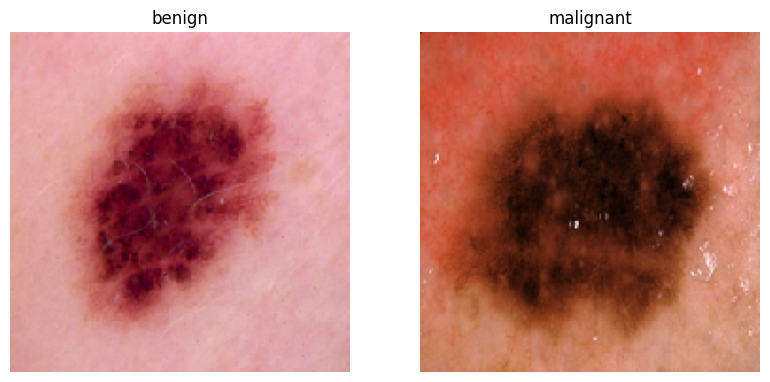

In [ ]:
#Visualize one instance of all the class present in the dataset.
from tensorflow.keras.preprocessing.image import load_img
#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [ ]:
 import pathlib
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,benign,1440
1,malignant,1197


<Axes: xlabel='No. of Image', ylabel='Class'>

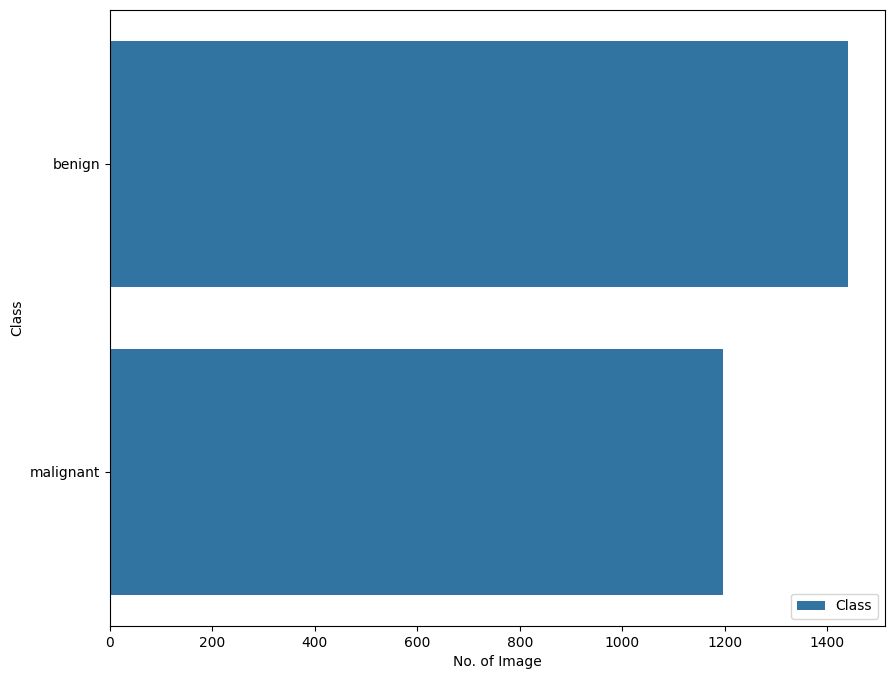

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [ ]:
#install Augmentor
!pip install Augmentor

In [ ]:
path_to_training_dataset="/content/train/" # Add a trailing slash

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i) # Now the path is correctly formed
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 1440 image(s) found.
Output directory set to /content/train/benign/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x79B73673F6D0>: 100%|██████████| 500/500 [00:06<00:00, 72.05 Samples/s]


Initialised with 1197 image(s) found.
Output directory set to /content/train/malignant/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x79B73410F7C0>: 100%|██████████| 500/500 [00:05<00:00, 87.05 Samples/s]


In [ ]:
import pathlib

#Count total number of image generated by Augmentor.
data_dir_train_path = pathlib.Path(data_dir_train) # Convert the string path to a Path object
image_count_train = len(list(data_dir_train_path.glob('*/output/*.jpg'))) # Use the Path object for glob
print(image_count_train)

1000


In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 3637 files belonging to 2 classes.
Using 2910 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 3637 files belonging to 2 classes.
Using 727 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Custom IoU function for classification
def iou_metric(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)

    # Cast to float for intersection and union calculation
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())  # Adding epsilon to avoid division by zero

    return iou


In [ ]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, confusion_matrix

# Import specific Keras layers and metrics
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Rescaling, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC  # Import AUC here

# Define the model architecture
model = Sequential()
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

# Convolutional layers
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout and Flatten layer
model.add(Dropout(0.5))
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(class_names), activation='softmax'))

# Compile the Model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', AUC(name='auc')])

# Check model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,647,234 (25.36 MB)

 Trainable params: 6,647,234 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Import necessary modules
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Stop training when the monitored metric (validation accuracy) stops improving
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)



In [ ]:
import tensorflow.keras.backend as K

def iou(y_true, y_pred):
    # Convert predictions to binary (0 or 1)
    y_pred = K.cast(y_pred > 0.5, K.floatx())

    # Intersection
    intersection = K.sum(y_true * y_pred)

    # Union
    union = K.sum(y_true) + K.sum(y_pred) - intersection

    # Compute IoU
    iou_score = intersection / (union + K.epsilon())
    return iou_score


In [ ]:
from tensorflow.keras.metrics import AUC
epochs=4
# Compile the model with custom IoU and AUC metrics
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy", AUC(name='auc'), iou])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint, earlystop])


Epoch 1/4
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6103 - auc: 0.6516 - iou: 0.4583 - loss: 0.9808
Epoch 1: val_accuracy improved from -inf to 0.76204, saving model to model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - accuracy: 0.6112 - auc: 0.6528 - iou: 0.4594 - loss: 0.9770 - val_accuracy: 0.7620 - val_auc: 0.8437 - val_iou: 0.6227 - val_loss: 0.4823
Epoch 2/4
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7703 - auc: 0.8579 - iou: 0.6339 - loss: 0.4685
Epoch 2: val_accuracy improved from 0.76204 to 0.80743, saving model to model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7704 - auc: 0.8580 - iou: 0.6340 - loss: 0.4683 - val_accuracy: 0.8074 - val_auc: 0.8896 - val_iou: 0.6856 - val_loss: 0.4253
Epoch 3/4
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7909 - auc: 0.8875 - iou: 0.6599 - loss: 0.4152
Epoch 3: val_accuracy did not improve from 0.80743
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7910 - auc: 0.8876 - iou: 0.660

In [ ]:
import tensorflow as tf

# Assuming X_test has shape (660, 224, 224, 3)
# Resize X_test to match the input shape of the model (180, 180, 3)
X_test_resized = tf.image.resize(X_test, [180, 180])

# Now you can use X_test_resized for prediction
y_pred_prob = model.predict(X_test_resized)

# ... (rest of your code)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


Accuracy:  0.8227272727272728
Precision:  0.8215231019270954
Recall:  0.8205555555555555
F1-Score:  0.8209910170964938
Average Precision:  0.9168863019696298
Mean Average Precision (mAP):  0.9118197234482528
Mean IoU:  0.696719287944701


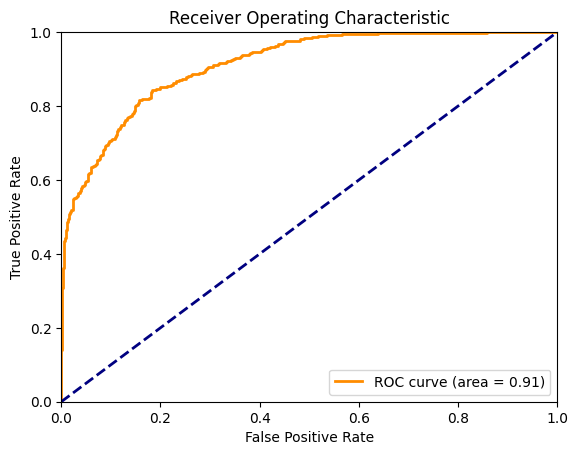

In [ ]:
# Accuracy, Precision, Recall, F1
y_test_classes = y_test

# Accuracy, Precision, Recall, F1
y_pred_classes = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)

# Average Precision and Mean Average Precision
y_test_onehot = to_categorical(y_test_classes)

ap = average_precision_score(y_test_onehot.ravel(), y_pred_prob.ravel())
map_score = np.mean([average_precision_score(y_test_onehot[:, i], y_pred_prob[:, i]) for i in range(len(class_names))])

print("Average Precision: ", ap)
print("Mean Average Precision (mAP): ", map_score)

from sklearn.metrics import jaccard_score  # Import jaccard_score for IoU

# ... (rest of your code)

# IoU Calculation
# Assuming you have y_test_classes and y_pred_classes as binary arrays
iou = jaccard_score(y_test_classes, y_pred_classes, average='macro')  # Calculate IoU
print("Mean IoU: ", iou)



# Plot ROC curve
# If y_test was one-hot encoded then y_test.ravel() would be correct
# but it is not so we will use y_test_onehot directly
fpr, tpr, _ = roc_curve(y_test_onehot.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

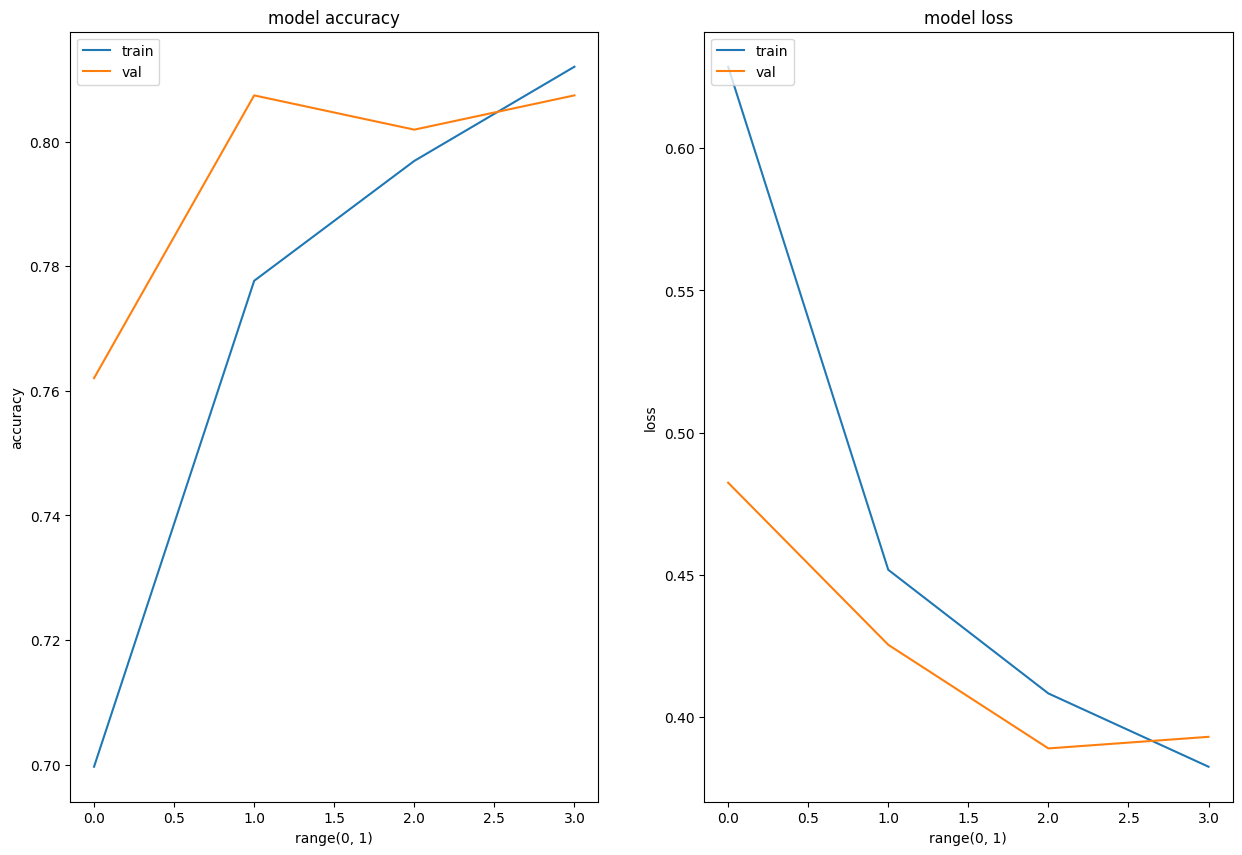

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Enter the path to the image: /content/test/benign/1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Predicted Class: benign


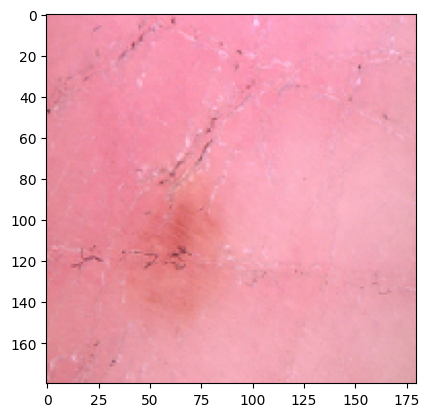

In [ ]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# Prompt user for the image path
user_image_path = input("Enter the path to the image: ")

# Load the image with the specified target size
Test_image = load_img(user_image_path, target_size=(180, 180))
plt.imshow(Test_image)
plt.grid(False)

# Convert the image to a numpy array and expand dimensions
img = img_to_array(Test_image)
img = np.expand_dims(img, axis=0)

# Make the prediction
pred = model.predict(img)
pred = np.argmax(pred)

# Assuming class_names is already defined
pred_class = class_names[pred]

# Print the result
print("Predicted Class: " + pred_class)


In [ ]:
from tensorflow.keras.applications import Xception, VGG19, ResNet50, InceptionV3, EfficientNetB0 # Import selected models

pretrained_model_specs = {
    'Xception': {
        'input_size': (299, 299),
        'preprocess_input': tf.keras.applications.xception.preprocess_input # Call preprocess_input directly from the module
    },
    'VGG19': {
        'input_size': (224, 224),
        'preprocess_input': tf.keras.applications.vgg19.preprocess_input # Call preprocess_input directly from the module
    },
    'ResNet50': {
        'input_size': (224, 224),
        'preprocess_input': tf.keras.applications.resnet50.preprocess_input # Call preprocess_input directly from the module
    },
    'InceptionV3': {
        'input_size': (299, 299),
        'preprocess_input': tf.keras.applications.inception_v3.preprocess_input # Call preprocess_input directly from the module
    },
    'EfficientNetB0': {
        'input_size': (224, 224),
        'preprocess_input': tf.keras.applications.efficientnet.preprocess_input # Call preprocess_input directly from the module
    },
}


In [ ]:
def create_pretrained_datasets(data_dir, input_size, batch_size=32, validation_split=0.2, seed=123, preprocess_input_fn=None):
    """
    Creates training and validation datasets for pre-trained models.

    Args:
        data_dir (str): Directory containing training data organized in subdirectories per class.
        input_size (tuple): Desired image size (height, width).
        batch_size (int): Batch size.
        validation_split (float): Fraction of data to reserve for validation.
        seed (int): Random seed.
        preprocess_input_fn (function): Preprocessing function specific to the model.

    Returns:
        train_ds, val_ds: TensorFlow datasets.
    """
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        image_size=input_size,
        label_mode='categorical',
        seed=seed,
        subset="training",
        validation_split=validation_split
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        image_size=input_size,
        label_mode='categorical',
        seed=seed,
        subset="validation",
        validation_split=validation_split
    )

    AUTOTUNE = tf.data.AUTOTUNE

    if preprocess_input_fn:
        train_ds = train_ds.map(lambda x, y: (preprocess_input_fn(x), y))
        val_ds = val_ds.map(lambda x, y: (preprocess_input_fn(x), y))

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds



In [ ]:
def build_pretrained_model(model_name, input_size, num_classes, preprocess_input_fn):
    """
    Builds and compiles a pre-trained model with custom top layers.

    Args:
        model_name (str): Name of the pre-trained model.
        input_size (tuple): Input image size.
        num_classes (int): Number of output classes.
        preprocess_input_fn (function): Preprocessing function.

    Returns:
        model: Compiled Keras model.
    """
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras import Model
    from tensorflow.keras.applications import Xception, VGG19, ResNet50, InceptionV3, MobileNetV2, DenseNet121, EfficientNetB0

    # Load the specified pre-trained base model
    if model_name == 'Xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=input_size + (3,))
    elif model_name == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_size + (3,))
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_size + (3,))
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_size + (3,))
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_size + (3,))
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Freeze the base model
    base_model.trainable = False

    # Create the model
    inputs = tf.keras.Input(shape=input_size + (3,))
    x = preprocess_input_fn(inputs)  # Apply the preprocess_input function
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
pretrained_results = {}

for model_name, specs in pretrained_model_specs.items():
    print(f"\n{'='*60}")
    print(f"Training Pre-trained Model: {model_name}")
    print(f"{'='*60}")

    # Extract specifications
    input_size = specs['input_size']
    preprocess_input_fn = specs['preprocess_input']

    # Create datasets tailored to the model's input size and preprocessing
    train_ds_pretrained, val_ds_pretrained = create_pretrained_datasets(
        data_dir=data_dir_train,
        input_size=input_size,
        preprocess_input_fn=preprocess_input_fn
    )

    # Build the pre-trained model
    pretrained_model = build_pretrained_model(
        model_name=model_name,
        input_size=input_size,
        num_classes=len(class_names),
        preprocess_input_fn=preprocess_input_fn
    )

    # Define callbacks
    checkpoint_pretrained = ModelCheckpoint(
        filepath=f"pretrained_{model_name}_best_model.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",  # Changed to 'max' since we are tracking accuracy
        verbose=1
    )
    earlystop_pretrained = EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        mode="max",  # Changed to 'max' for accuracy
        verbose=1
    )
    reduce_lr_pretrained = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        verbose=1
    )
    callbacks_pretrained = [checkpoint_pretrained, earlystop_pretrained, reduce_lr_pretrained]

    # Train the pre-trained model
    epochs_pretrained = 1  # Adjust based on resource availability
    history_pretrained = pretrained_model.fit(
        train_ds_pretrained,
        validation_data=val_ds_pretrained,
        epochs=epochs_pretrained,
        callbacks=callbacks_pretrained
    )

    # Load the best saved model
    best_pretrained_model = tf.keras.models.load_model(f"pretrained_{model_name}_best_model.keras")  # Corrected the extension

    # Evaluate on validation data
    val_loss_pretrained, val_accuracy_pretrained = best_pretrained_model.evaluate(val_ds_pretrained)
    print(f"Validation Accuracy for {model_name}: {val_accuracy_pretrained*100:.2f}%")

    # Store the results
    pretrained_results[model_name] = {
        'history': history_pretrained.history,
        'val_accuracy': val_accuracy_pretrained,
        'val_loss': val_loss_pretrained
    }

    # Clear the session to free memory
    tf.keras.backend.clear_session()



Training Pre-trained Model: Xception
Found 3637 files belonging to 2 classes.
Using 2910 files for training.
Found 3637 files belonging to 2 classes.
Using 727 files for validation.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.5434 - loss: 0.6976
Epoch 1: val_accuracy improved from -inf to 0.56121, saving model to pretrained_Xception_best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 90s 653ms/step - accuracy: 0.5433 - loss: 0.6976 - val_accuracy: 0.5612 - val_loss: 0.6764 - learning_rate: 1.0000e-04
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.5779 - loss: 0.6726
Validation Accuracy for Xception: 56.12%

Training Pre-trained Model: VGG19
Found 3637 files belonging to 2 classes.
Using 2910 files for training.
Found 3637 files belonging to 2 classes.
Using 727 files for validation.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6045 - loss: 1.5343
Epoch 1: val_accu

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
import numpy as np

# Assuming that the model is binary or multi-class classification
def compute_metrics(y_true, y_pred, class_names):
    # Convert predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Convert y_true to a 1D array of class labels if it's one-hot encoded
    if y_true.ndim == 2 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true_labels = np.argmax(y_true, axis=1)  # Convert to class labels
    else:
        y_true_labels = y_true  # If not one-hot encoded, use as is

    # Classification report (includes precision, recall, f1-score, support)
    class_report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)

    # AUC for multi-class (One-vs-Rest approach)
    auc_score = roc_auc_score(y_true, y_pred, multi_class="ovr") # Use y_true_labels for AUC

    # Extracting precision, recall, f1-score for each class
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1 = class_report['weighted avg']['f1-score']

    return precision, recall, f1, auc_score
# Find the best model based on validation accuracy
best_model_name = None
best_val_accuracy = 0.0

for model_name, results in pretrained_results.items():
    val_accuracy = results['val_accuracy']
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_name = model_name

# Print the best model and its accuracy
print(f"\n{'='*60}")
print(f"The best model is: {best_model_name}")
print(f"Validation Accuracy: {best_val_accuracy*100:.2f}%")
print(f"{'='*60}")

# Load the best saved model again (optional, if necessary)
best_pretrained_model = tf.keras.models.load_model(f"pretrained_{best_model_name}_best_model.keras")

# Evaluate on the validation data to get the actual labels and predicted probabilities
val_loss, val_accuracy = best_pretrained_model.evaluate(val_ds_pretrained)
y_true = np.concatenate([y for x, y in val_ds_pretrained], axis=0)  # Get true labels from the dataset
y_pred = best_pretrained_model.predict(val_ds_pretrained)  # Predict probabilities

# Compute metrics
precision, recall, f1, auc_score = compute_metrics(y_true, y_pred, class_names)

# Print detailed metrics
print(f"\n{'='*60}")
print(f"Performance Metrics for the best model ({best_model_name}):")
print(f"Validation Accuracy: {best_val_accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")
print(f"AUC: {auc_score:.4f}")
print(f"{'='*60}")



The best model is: ResNet50
Validation Accuracy: 84.46%
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.7998 - loss: 0.4486
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step

Performance Metrics for the best model (ResNet50):
Validation Accuracy: 84.46%
Precision: 80.88%
Recall: 80.88%
F1-Score: 80.87%
AUC: 0.8824


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
import numpy as np


# Function to get predictions from the CNN model
def get_cnn_predictions(cnn_model, val_ds):
    y_pred_cnn = cnn_model.predict(val_ds)
    return y_pred_cnn

# Function to get predictions from the ResNet50 model
def get_resnet50_predictions(resnet50_model, val_ds):
    y_pred_resnet50 = resnet50_model.predict(val_ds)
    return y_pred_resnet50

# Function to perform ensemble by averaging predictions
def ensemble_predictions(cnn_preds, resnet50_preds):
    # Averaging the predicted probabilities from both models
    avg_preds = (cnn_preds + resnet50_preds) / 2
    return avg_preds

# Get true labels from the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)  # Assuming 'val_ds' is your validation dataset

# Get predictions from both CNN and ResNet50 models
cnn_model_predictions = get_cnn_predictions(model, val_ds)  # 'model' is your CNN
resnet50_model_predictions = get_resnet50_predictions(best_pretrained_model, val_ds)  # Assuming 'best_pretrained_model' is ResNet50

# Perform ensemble by averaging the predictions
ensemble_preds = ensemble_predictions(cnn_model_predictions, resnet50_model_predictions)

# (Rest of the code for computing and printing metrics remains the same)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(y_true, y_pred, class_names):
    # Convert predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Ensure y_true is a 1D array of class labels
    y_true_labels = np.argmax(y_true, axis=1) if y_true.ndim == 2 and y_true.shape[1] > 1 else y_true

    # Calculate accuracy
    accuracy_ensemble = accuracy_score(y_true_labels, y_pred_labels)

    # Classification report (includes precision, recall, f1-score, support)
    class_report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)


    # AUC for multi-class (One-vs-Rest approach)
    auc_score = roc_auc_score(y_true, y_pred, multi_class="ovr")  # Use y_true_labels for AUC as well

    # Extracting precision, recall, f1-score for each class
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1 = class_report['weighted avg']['f1-score']

    return accuracy_ensemble, precision, recall, f1, auc_score

# Compute metrics for the ensemble predictions
accuracy_ensemble, precision_ensemble, recall_ensemble, f1_ensemble, auc_ensemble = compute_metrics(y_true, ensemble_preds, class_names)

# Print detailed ensemble metrics
print(f"\n{'='*60}")
print(f"Performance Metrics for the Ensemble Model (CNN + Pre-trained):")
print(f"Accuracy: {accuracy_ensemble*100:.2f}%")
print(f"Precision: {precision_ensemble*100:.2f}%")
print(f"Recall: {recall_ensemble*100:.2f}%")
print(f"F1-Score: {f1_ensemble*100:.2f}%")
print(f"AUC: {auc_ensemble:.4f}")
print(f"{'='*60}")


Performance Metrics for the Ensemble Model (CNN + Pre-trained):
Accuracy: 78.82%
Precision: 79.54%
Recall: 78.82%
F1-Score: 78.77%
AUC: 0.8732


Enter the path to the image: /content/test/benign/1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class (Ensemble): malignant


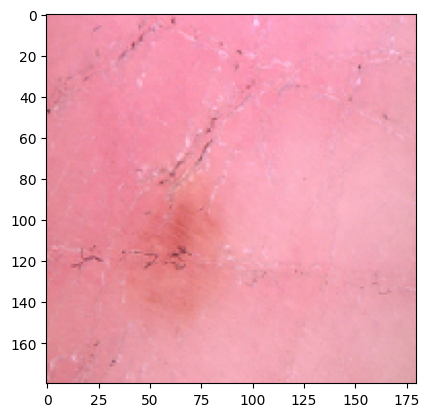

In [ ]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array


# Prompt user for the image path
user_image_path = input("Enter the path to the image: ")

# Load the image with the specified target size for both models
img_cnn = load_img(user_image_path, target_size=(180, 180))  # For CNN
img_resnet50 = load_img(user_image_path, target_size=(224, 224))  # For ResNet50

plt.imshow(img_cnn)  # Display the image (using the CNN size)
plt.grid(False)

# Convert images to numpy arrays and expand dimensions
img_cnn = img_to_array(img_cnn)
img_cnn = np.expand_dims(img_cnn, axis=0)

img_resnet50 = img_to_array(img_resnet50)
img_resnet50 = np.expand_dims(img_resnet50, axis=0)

# Make predictions using both models
pred_cnn = model.predict(img_cnn)  # 'model' is your CNN
pred_resnet50 = best_pretrained_model.predict(img_resnet50)  # 'best_pretrained_model' is ResNet50

# Ensemble predictions by averaging
ensemble_pred = (pred_cnn + pred_resnet50) / 2

# Get predicted class
pred_class_index = np.argmax(ensemble_pred)
pred_class = class_names[pred_class_index]  # Assuming 'class_names' is defined

# Print the result
print("Predicted Class (Ensemble): " + pred_class)

In [ ]:
import numpy as np
import tensorflow as tf
import os

# 1. Load the Best Model
# Assuming 'best_pretrained_model' is your best model
best_model = best_pretrained_model  # Replace with your actual best model variable

# 2. Get the 4th Block
# Assuming your model is a sequential model and the 4th block is a layer
# with name 'block4_conv1'
block4_layer = best_model.get_layer('input_layer_1')  # Replace with your layer name

# Create a sub-model to extract the output of the 4th block
block4_output_model = tf.keras.Model(inputs=best_model.input, outputs=block4_layer.output)

# 3. Extract Features from Validation Data
# Assuming 'val_ds' is your validation dataset
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize to (224, 224)
    return image, label

val_ds_resized = val_ds.map(preprocess_image)  # Apply resizing to val_ds

features = block4_output_model.predict(val_ds_resized)  # Use the resized dataset

#features = block4_output_model.predict(val_ds)

# 4. Convert to NumPy Matrix
features_matrix = np.array(features)

# 5. Create a Folder and Save
folder_name = 'block4_features'
os.makedirs(folder_name, exist_ok=True)  # Create folder if it doesn't exist

# Save the matrix to a file (e.g., using NumPy's save)
np.save(os.path.join(folder_name, 'features.npy'), features_matrix)

print(f"Features extracted and saved to '{folder_name}/features.npy'")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Features extracted and saved to 'block4_features/features.npy'


In [ ]:
import numpy as np
import tensorflow as tf
import os

# ... (Previous code for loading model and extracting features) ...

# 5. Add a Dense Layer
num_features = features_matrix.shape[-1]  # Get the number of features

# Reshape features_matrix to 2D before applying Dense layer
features_matrix_2d = features_matrix.reshape(features_matrix.shape[0], -1)

dense_layer = tf.keras.layers.Dense(units=128, activation='relu')  # Example: 128 units, ReLU activation
dense_output = dense_layer(features_matrix_2d)  # Apply Dense layer to reshaped features

# 6. Create a Folder and Save
folder_name = 'block4_features_dense'
os.makedirs(folder_name, exist_ok=True)

# Save the output of the dense layer to a file
np.save(os.path.join(folder_name, 'dense_features.npy'), dense_output)

print(f"Features with dense layer output saved to '{folder_name}/dense_features.npy'")

Features with dense layer output saved to 'block4_features_dense/dense_features.npy'


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Load the Dense Features
dense_features = np.load('block4_features_dense/dense_features.npy')

print(f"Shape of dense_features: {dense_features.shape}")
print(f"Shape of y_train: {y_train.shape}")

# Once the shapes are consistent, you can proceed with train_test_split:
X_train_dense, X_test_dense, y_train_dense, y_test_dense = train_test_split(
    dense_features, y_train[:dense_features.shape[0]], test_size=0.2, random_state=42  # Adjust test_size and random_state as needed
)

Shape of dense_features: (727, 128)
Shape of y_train: (2637,)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the hyperparameter search space for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Create and train the Logistic Regression model with GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_dense, y_train_dense)

# Get the best model and its hyperparameters
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")

# Evaluate the best model on the test data
y_pred_dense_tuned = best_estimator.predict(X_test_dense)

accuracy_tuned = accuracy_score(y_test_dense, y_pred_dense_tuned)
precision_tuned = precision_score(y_test_dense, y_pred_dense_tuned)
recall_tuned = recall_score(y_test_dense, y_pred_dense_tuned)
f1_tuned = f1_score(y_test_dense, y_pred_dense_tuned)

print("Performance Metrics (Tuned):")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1-Score: {f1_tuned}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Performance Metrics (Tuned):
Accuracy: 0.4794520547945205
Precision: 0.38181818181818183
Recall: 0.3333333333333333
F1-Score: 0.3559322033898305


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
